# 格子細胞のデコーディング

## グリッド細胞(Grid Cells)

### 空間基底としてのグリッド細胞
海馬には場所特異的に発火する**場所細胞**(place cell)があり，これはO'keefeによって発見された．次にMay-Britt MoserとEdvard Moserが六角形格子状の場所受容野を持つ**グリッド細胞**(格子細胞, grid cell)を内側嗅内皮質(medial entorhinal cortex; MEC)で発見した．この3人は2014年のノーベル生理学・医学賞を受賞している．

### データについて

格子細胞の活動データはMoser研が公開しており，<https://www.ntnu.edu/kavli/research/grid-cell-data>からダウンロードできる．公開されているデータはMATLABのmatファイル形式である．使用するデータ：[10704-07070407_POS.mat](https://github.com/Salad-bowl-of-knowledge/hp/blob/master/_notebooks/data/grid_cells_data/10704-07070407_POS.mat), [10704-07070407_T2C3.mat](https://github.com/Salad-bowl-of-knowledge/hp/blob/master/_notebooks/data/grid_cells_data/10704-07070407_T2C3.mat)

これらのファイルは<https://archive.norstore.no/pages/public/datasetDetail.jsf?id=8F6BE356-3277-475C-87B1-C7A977632DA7>からダウンロードできるファイルの一部である．以下では`./data/grid_cells_data/`ディレクトリの下にファイルを置いている．

データの末尾の"POS"と"T2C3"の意味について説明しておく．まず，"POS"はpost, posx, posyを含む構造体でそれぞれ試行の経過時間，x座標, y座標である．座標は$[-50, 50]$で記録されている．1m四方の正方形の部屋で，原点を部屋の中心としている．"T2C3"はtがtetrode（テトロード電極）でcがcell（細胞）を意味する．後ろの数字は番号付けである． 

## ラットの行動軌跡と発火の描画

データを読み込む．

In [1]:
using PyPlot, MAT, StatsBase, FFTW

In [2]:
# from http://www.ntnu.edu/kavli/research/grid-cell-data
pos = matopen("../_static/datasets/grid_cells_data/10704-07070407_POS.mat")
spk = matopen("../_static/datasets/grid_cells_data/10704-07070407_T2C3.mat")

MAT.MAT_v5.Matlabv5File(IOStream(<file ../_static/datasets/grid_cells_data/10704-07070407_T2C3.mat>), false, #undef)

posファイル内の構造は次のようになっている．
- `pos["post"]`: times at which positions were recorded
- `pos["posx"]`: x positions
- `pos["posy"]`: y positions
- `spk["cellTS"]`: spike times

In [3]:
post = read(pos, "post")[:] #  times at which positions were recorded
posx = read(pos, "posx")[:] #x positions
posy = read(pos, "posy")[:] # y positions
spkt = read(spk, "cellTS")[:] #spike time

println(size(post), size(posx), size(posy), size(spkt))

(30000,)(30000,)(30000,)(2326,)


行動軌跡を描画する．

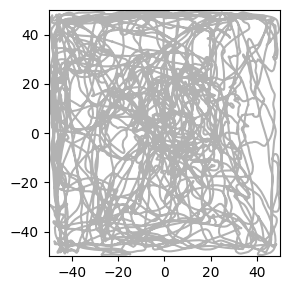

In [4]:
figure(figsize=(3,3))
plot(posx, posy, color="k", alpha=0.3)
xlim(-50, 50); ylim(-50, 50)
tight_layout()

発火を描画するために発火時刻 `spkt` のそれぞれの要素と最も近い `post` のインデックスを求める関数を実装する．

In [5]:
function nearest_pos(array, value)
    idx = argmin(abs.(array .- value))
    return idx
end

nearest_pos (generic function with 1 method)

In [6]:
idx = [nearest_pos(post, t) for t in spkt]

print(size(idx))

(2326,)

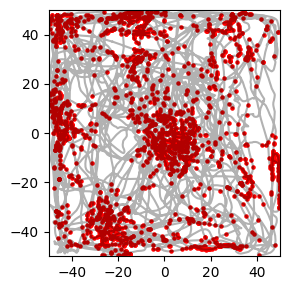

In [7]:
figure(figsize=(3,3))
plot(posx, posy, color="k", alpha=0.3)
scatter(posx[idx], posy[idx], color="r", s=5)
xlim(-50, 50); ylim(-50, 50)
tight_layout()

## 発火率マップ

発火率$\lambda(\boldsymbol{x})$は，場所$\boldsymbol{x}=(x,y)$で記録されたスパイクの回数を，場所$\boldsymbol{x}$における滞在時間(s)で割ることで得られる． 

$$ 
\lambda(\boldsymbol{x})=\frac{\displaystyle \sum_{i=1}^n
g\left(\frac{\boldsymbol{s}_i-\boldsymbol{x}}{h}\right)}{\displaystyle \int_0^T g\left(\frac{\boldsymbol{y}(t)-\boldsymbol{x}}{h}\right)dt} 
$$ 

ただし，$n$はスパイクの回数，$T$は計測時間，$g(\cdot)$はGaussain
Kernel（中身の分子が平均，分母が標準偏差），$\boldsymbol{s}_i$は$i$番目のスパイクの発生した位置，$\boldsymbol{y}(t)$は時刻$t$でのラットの位置である．分母は積分になっているが，実際には離散的に記録をするので，累積和に変更し，$dt$を時間のステップ幅(今回は0.02s)とする．

この式の分母はマウスの位置，分子はニューロンが発火したときのマウスの位置についてそれぞれカーネル密度推定 (kernel density estimation)を行うことを意味する．今回はヒストグラムを求め，描画の際にGaussianで平滑化することで計算量を下げることとする．

発火数のヒストグラムを描画する．PyPlotで`hist2D(posx[idx], posy[idx], bins=10, cmap="jet")`などとする方が簡便だが，今回はhistgramの各binの値を用いるために`StatsBase.jl`を用いる．

In [8]:
activ_hist = fit(Histogram, (posy[idx], posx[idx]), (-50:10:50, -50:10:50)).weights # activation
occup_hist = fit(Histogram, (posy, posx), (-50:10:50, -50:10:50)).weights　# occup position while trajectory 
occup_hist *= 0.02 # one time step is 0.02s 
occup_hist[occup_hist .== 0] .= 1 # avoid devide by zero

rate_hist = activ_hist ./ occup_hist;

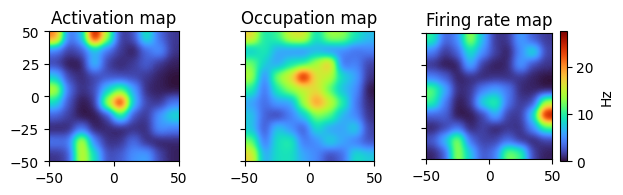

In [9]:
fig, ax = subplots(1, 3, figsize=(6.5, 2), sharex="all", sharey="all")
titles = ["Activation map", "Occupation map", "Firing rate map"]
hists = [activ_hist, occup_hist, rate_hist]
for (i, (t, h)) in enumerate(zip(titles, hists))
    ax[i].set_title(t)
    ims = ax[i].imshow(h, origin="lower", cmap="turbo", interpolation="gaussian", extent=[-50, 50, -50, 50])
    if i == 3
        fig.colorbar(ims, label="Hz", ax=ax[i])
    end
end
tight_layout()

## Autocorrelation Map

2次元の自己相関マップ (autocorrelation map)を描画する．

In [10]:
function correlate_fft(x, y)
    corr = fftshift(real(ifft(fft(x) .* conj(fft(y)))))
    return corr / maximum(corr)
end;

In [11]:
corr_map = correlate_fft(rate_hist, rate_hist);

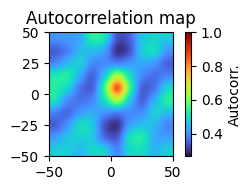

In [12]:
figure(figsize=(3, 2))
title("Autocorrelation map")
imshow(corr_map, origin="lower", cmap="turbo", interpolation="gaussian", extent=[-50, 50, -50, 50])
colorbar(label="Autocorr.")
tight_layout()

## 参考にした文献・サイト
- <https://github.com/Felix11H/grid_cell_rate_map>
- <https://www.ntnu.edu/kavli/research/grid-cell-data>
- <https://core.ac.uk/download/pdf/30859910.pdf>のSupporting Online Material
- <https://github.com/MattNolanLab/gridcells>
- <https://arxiv.org/pdf/1810.07429.pdf>
- <https://www.diogosantospata.com/gridcells/>